In [1]:
import numpy as np
import scipy
import time
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
FROM_DATASET = True
USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
OUTPUT_STEP = 0.1
N_SAMPLES = 4200
PARTITION = int(N_SAMPLES*0.1)
NUM_ITERS = 60
EPSILON = 1e-5
PLOT_DPI = 150
OPTIMIZE_RANDOM = False

In [4]:

if not FROM_DATASET:
    # Set random seed for reproducibility
    np.random.seed(420)

    # Create dataset with 10,000 points and 2 clusters
    #X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
    X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
    y = np.where(y == 0, -1, y)

    # Print the shapes of X and y
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Create scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

    # Add axis labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

    # Show the plot
    plt.show()

else:

    data = np.genfromtxt('diabetes.csv', delimiter=',', skip_header=1)
    X = data[:, :-1]
    y = data[:, -1]
    y = np.where(y == 0, -1, y)


In [8]:
print("Dataset Lenght")
print("Tot: " + str(len(X)) + ", lab: " + str(PARTITION) + ", unlab: " + str(len(X)-PARTITION))

Dataset Lenght
Tot: 768, lab: 420, unlab: 348


In [41]:
import collections

# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

unlabeled_X.shape

# Label initialization
y_labeled = np.array(y[:PARTITION])
collections.Counter(y_labeled)

y_unlabeled_target = np.array(y[PARTITION:])

y_unlabeled_initial = np.random.choice([-1,1], size = (len(unlabeled_X,)))

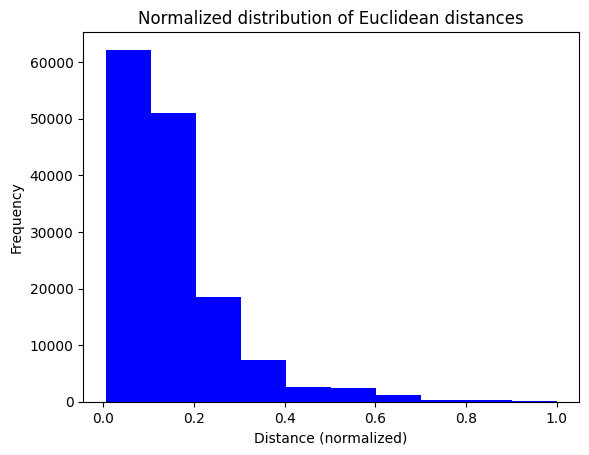

(420, 348)

In [42]:
import math
import seaborn as sns

labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

len(labeled_distances[0])

labeled_dist_matrix = np.array(labeled_distances)

labeled_dist_matrix.shape

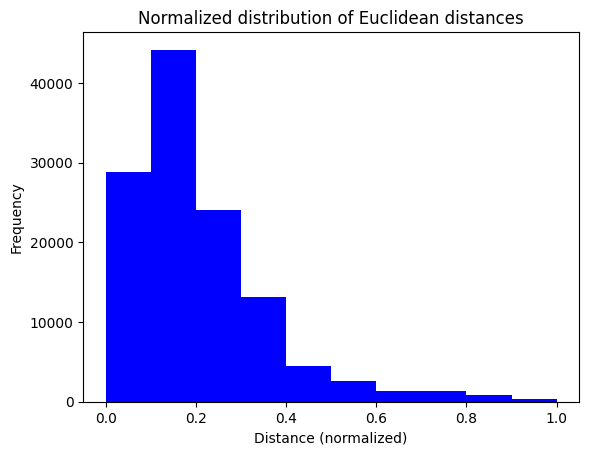

(348, 348)

In [43]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

unlabeled_distances.shape


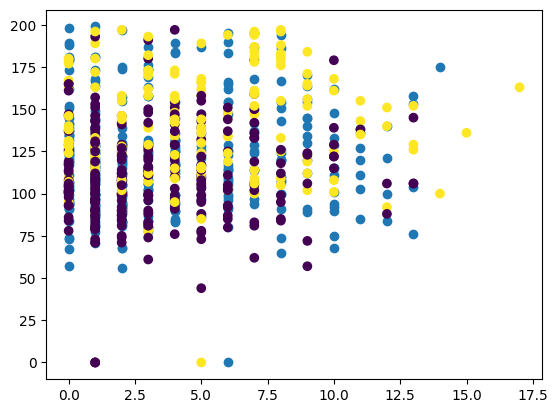

In [44]:
plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=y_labeled)

plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [45]:
def weight(dist):
    return math.e**(-10*dist**2)

In [46]:
%%time
print("Calculating weights between labeled points and unlabeled points")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
print('Done')

print("Calculating weights between unlabeled points and unlabeled points")
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Calculating weights between labeled points and unlabeled points
Done
Calculating weights between unlabeled points and unlabeled points
Done
CPU times: user 121 ms, sys: 8.02 ms, total: 129 ms
Wall time: 128 ms


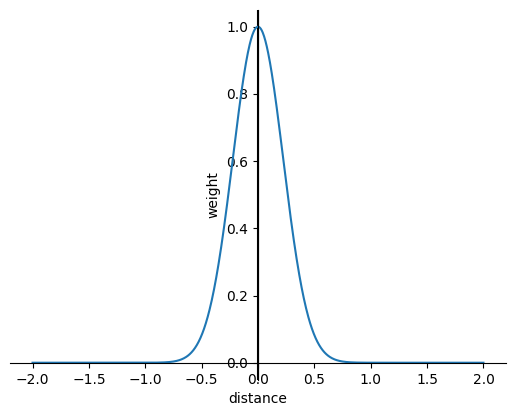

In [47]:
X = np.linspace(-2, 2, 1000)
plt.figure(dpi=100)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")

The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [48]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * labeled_unlabeled_weights.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * unlabeled_unlabeled_weights.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [49]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)
max_loss = np.sum(labeled_unlabeled_weights) * 4 + np.sum(unlabeled_unlabeled_weights) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=2)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=2)
    return 1 - current_distance / initial_distance

def accuracy(current):
    return accuracy_round(current) #loss(y_labeled, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$


### Hessian and constants

In [50]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(labeled_unlabeled_weights[:,i]) + np.sum(unlabeled_unlabeled_weights[:,i]) - unlabeled_unlabeled_weights[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 
Calculating sigma (strongly convex)
Sigma: 62.7540868914104,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 1004.3461132826552
Estimating Lipschitz constant for each single variable
Done
CPU times: user 86.8 ms, sys: 190 ms, total: 277 ms
Wall time: 74.1 ms


Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [51]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    y_labeled.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [52]:
def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [53]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [54]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")

00% - iter 0 / 60 - final accuracy 72.41% - loss 109688.19
10% - iter 6 / 60 - final accuracy 70.11% - loss 105610.81
20% - iter 12 / 60 - final accuracy 70.11% - loss 105561.40
30% - iter 18 / 60 - final accuracy 70.11% - loss 105551.32
40% - iter 24 / 60 - final accuracy 70.11% - loss 105548.38
50% - iter 30 / 60 - final accuracy 69.83% - loss 105547.34
60% - iter 36 / 60 - final accuracy 69.83% - loss 105546.92
70% - iter 42 / 60 - final accuracy 69.83% - loss 105546.74
80% - iter 48 / 60 - final accuracy 69.83% - loss 105546.65
90% - iter 54 / 60 - final accuracy 69.83% - loss 105546.61

Final accuracy: 69.83%
Norm gradient: 1.2710331958582228
Loss: 105546.59523009475

CPU times: user 845 ms, sys: 558 ms, total: 1.4 s
Wall time: 784 ms


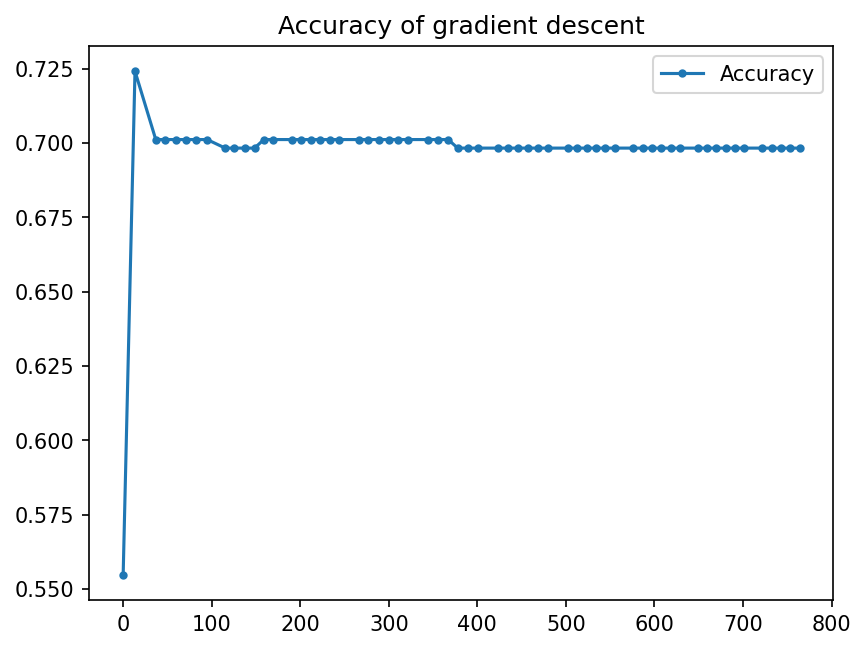

In [55]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [56]:
y_unlabeled_gd_improved = np.copy(y_unlabeled_initial)

In [57]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(y_labeled, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(y_labeled, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(y_labeled, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 60 - final accuracy 45.40% - loss 210452.34
10% - iter 6 / 60 - final accuracy 65.80% - loss 111904.55
20% - iter 12 / 60 - final accuracy 70.11% - loss 106156.84
30% - iter 18 / 60 - final accuracy 69.83% - loss 105622.60
40% - iter 24 / 60 - final accuracy 69.83% - loss 105557.77
50% - iter 30 / 60 - final accuracy 69.83% - loss 105548.40
60% - iter 36 / 60 - final accuracy 69.83% - loss 105546.88
70% - iter 42 / 60 - final accuracy 69.83% - loss 105546.62
80% - iter 48 / 60 - final accuracy 69.83% - loss 105546.58
90% - iter 54 / 60 - final accuracy 69.83% - loss 105546.57

Final accuracy: 69.83%
Norm gradient: 0.9243942404857278
Loss: 105546.56770821866

CPU times: user 766 ms, sys: 10.9 ms, total: 776 ms
Wall time: 784 ms


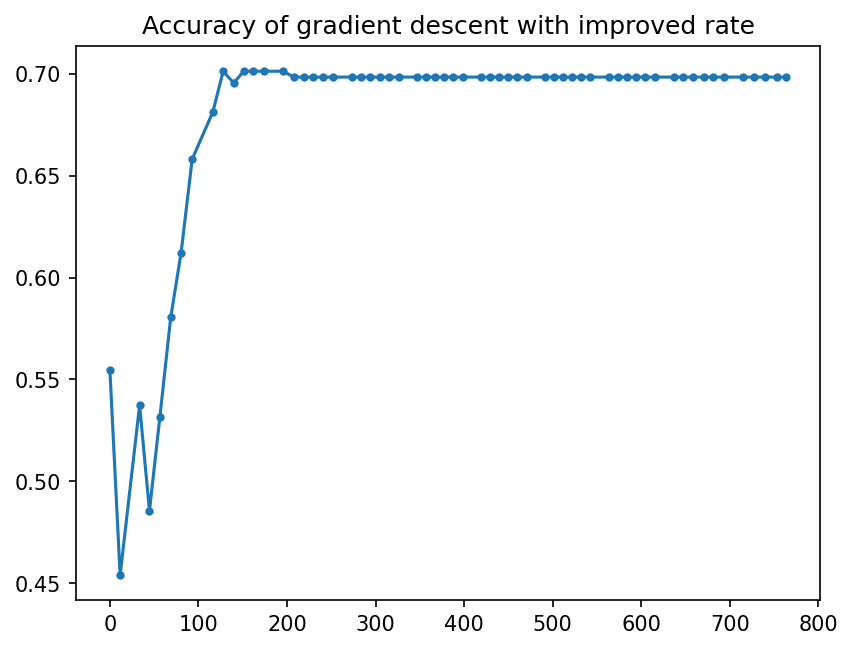

In [58]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Heavy ball

In [59]:
y_unlabeled_gd_hb_previous = y_unlabeled_gd_hb = np.copy(y_unlabeled_initial)

In [60]:
%%time
ticks_gd_hb = [0]
accuracies_gd_hb = [accuracy(y_unlabeled_gd_hb)]
losses_gd_hb = [loss(y_labeled, y_unlabeled_gd_hb)]
init_time = time.time() * 1000
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_hb)
    if EPSILON >= np.linalg.norm(grad):
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_gd_hb - y_unlabeled_gd_hb_previous)

    old_y_unlabeled_gd_hb = np.copy(y_unlabeled_gd_hb)
    y_unlabeled_gd_hb = y_unlabeled_gd_hb - 1/L * grad + momentum
    y_unlabeled_gd_hb_previous = old_y_unlabeled_gd_hb

    accuracies_gd_hb.append(accuracy(y_unlabeled_gd_hb))
    losses_gd_hb.append(loss(y_labeled, y_unlabeled_gd_hb))
    ticks_gd_hb.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_hb[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_hb):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_hb[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_hb))}
Loss: {loss(y_labeled, y_unlabeled_gd_hb)}
""")

00% - iter 0 / 60 - final accuracy 72.41% - loss 109688.19
10% - iter 6 / 60 - final accuracy 70.11% - loss 105983.96
20% - iter 12 / 60 - final accuracy 69.83% - loss 105704.81
30% - iter 18 / 60 - final accuracy 69.83% - loss 105614.05
40% - iter 24 / 60 - final accuracy 69.83% - loss 105581.43
50% - iter 30 / 60 - final accuracy 70.11% - loss 105565.52
60% - iter 36 / 60 - final accuracy 69.83% - loss 105558.38
70% - iter 42 / 60 - final accuracy 69.54% - loss 105554.17
80% - iter 48 / 60 - final accuracy 69.83% - loss 105551.36
90% - iter 54 / 60 - final accuracy 70.11% - loss 105549.85

Final accuracy: 69.83%
Norm gradient: 57.296282821987795
Loss: 105549.03011274929

CPU times: user 757 ms, sys: 9.7 ms, total: 767 ms
Wall time: 766 ms


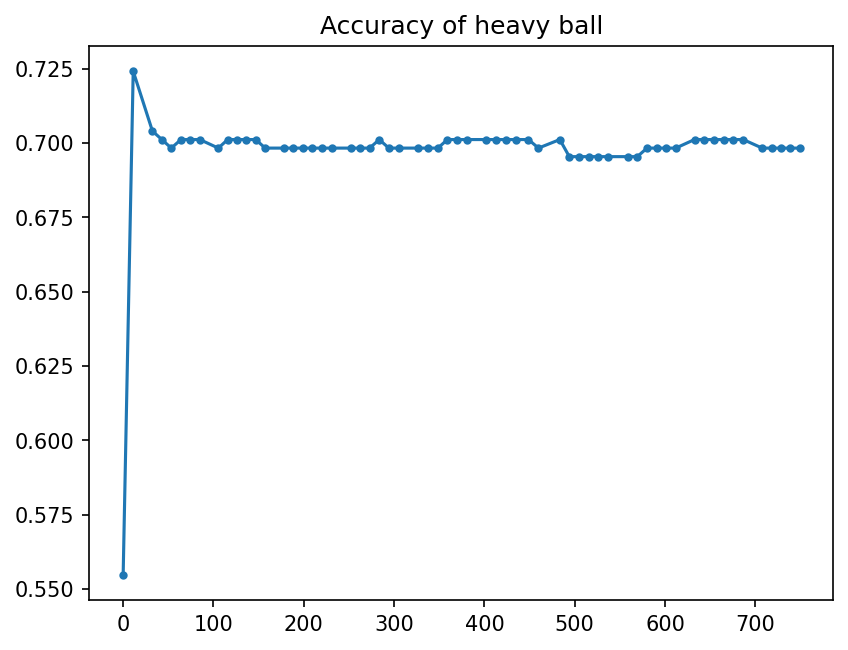

In [61]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of heavy ball")
plt.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')

### Accelerated Gradient

In [62]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(y_unlabeled_initial)

In [63]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(y_labeled, y_unlabeled_gd_accelerated)]
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)
    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated

    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(y_labeled, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(y_labeled, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 60 - final accuracy 72.41% - loss 109688.19
10% - iter 6 / 60 - final accuracy 70.11% - loss 105556.66
20% - iter 12 / 60 - final accuracy 70.11% - loss 105547.50
30% - iter 18 / 60 - final accuracy 69.54% - loss 105546.74
40% - iter 24 / 60 - final accuracy 69.83% - loss 105546.59
50% - iter 30 / 60 - final accuracy 69.83% - loss 105546.61
60% - iter 36 / 60 - final accuracy 69.83% - loss 105546.58
70% - iter 42 / 60 - final accuracy 69.83% - loss 105546.56
80% - iter 48 / 60 - final accuracy 69.83% - loss 105546.56
90% - iter 54 / 60 - final accuracy 69.83% - loss 105546.57

Final accuracy: 69.83%
Norm gradient: 0.18622077519814983
Loss: 105546.5699442562

CPU times: user 753 ms, sys: 7.02 ms, total: 760 ms
Wall time: 757 ms


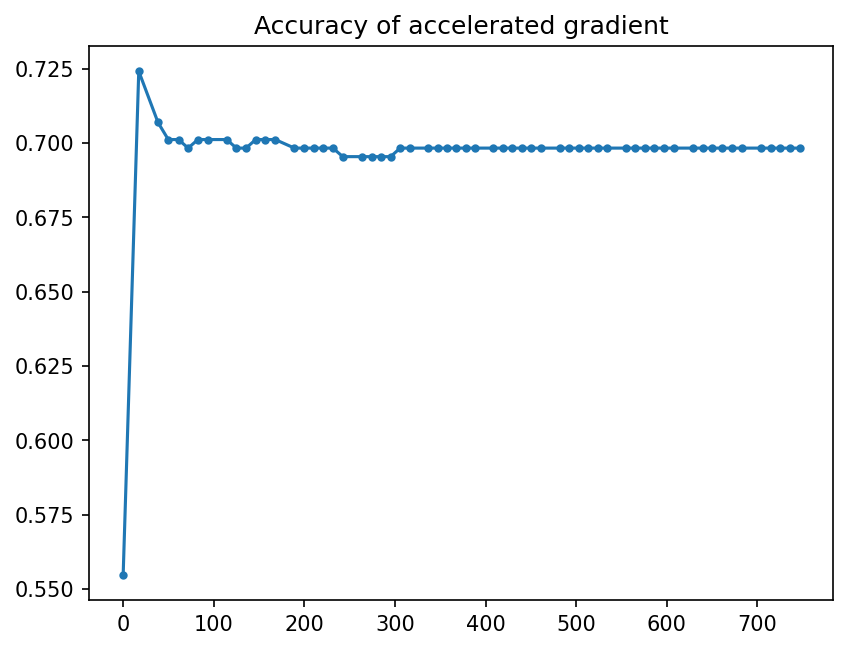

In [64]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of accelerated gradient")
plt.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [65]:
def derivative(unlabeled, j):
    return grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T)

def derivative_iterative(labeled, unlabeled, j):
    tot = 0
    for i in range(len(labeled)):
        tot += 2*w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
    for i in range(len(unlabeled)):
        tot += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
    return tot

def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [66]:
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [67]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(y_labeled, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.choice(len(y_unlabeled_bcgd_random), max_iterations, p=optimized_sampling_probabilities)[0] \
    if OPTIMIZE_RANDOM else np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(y_labeled, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 20880 - final accuracy 55.46% - loss 303918.69
10% - iter 2088 / 20880 - final accuracy 69.54% - loss 107799.75
20% - iter 4176 / 20880 - final accuracy 69.83% - loss 105566.32
30% - iter 6264 / 20880 - final accuracy 70.11% - loss 105555.52
40% - iter 8352 / 20880 - final accuracy 69.83% - loss 105549.12
50% - iter 10440 / 20880 - final accuracy 69.83% - loss 105547.74
60% - iter 12528 / 20880 - final accuracy 69.83% - loss 105547.35
70% - iter 14616 / 20880 - final accuracy 69.83% - loss 105546.99
80% - iter 16704 / 20880 - final accuracy 69.83% - loss 105546.78
90% - iter 18792 / 20880 - final accuracy 69.83% - loss 105546.66

Final accuracy: 69.83%
Norm gradient: 1.9947383606688869
Loss: 105546.62452108969

CPU times: user 1.21 s, sys: 11.4 ms, total: 1.23 s
Wall time: 1.22 s


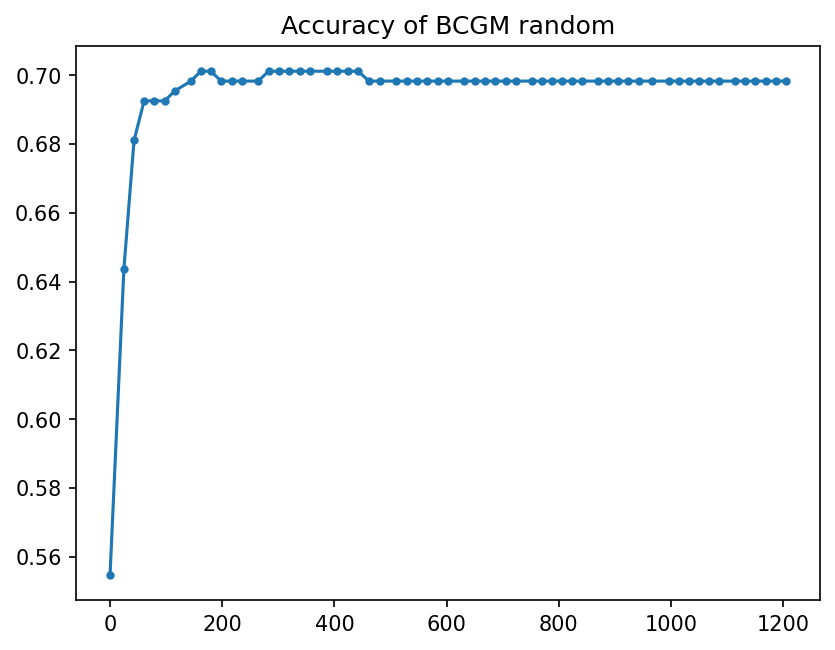

In [68]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Cyclic

In [69]:
y_unlabeled_bcgd_cyclic = np.copy(y_unlabeled_initial).astype("float64")

In [70]:
%%time
ticks_bcgd_cyclic= [0]
accuracies_bcgd_cyclic= [accuracy(y_unlabeled_bcgd_cyclic)]
losses_bcgm_cyclic = [loss(y_labeled, y_unlabeled_bcgd_cyclic)]

previous_grad_cyclic = gradient(y_unlabeled_bcgd_cyclic)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_cyclic)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = i % len(y_unlabeled_bcgd_cyclic)

    step, new_grad = update_gradient(previous_grad_cyclic, Li, index)
    y_unlabeled_bcgd_cyclic[index] = y_unlabeled_bcgd_cyclic[index] - step
    previous_grad_cyclic = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_cyclic):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_cyclic.append(accuracy(y_unlabeled_bcgd_cyclic))
        losses_bcgm_cyclic.append(loss(y_labeled, y_unlabeled_bcgd_cyclic))
        ticks_bcgd_cyclic.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_cyclic[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_cyclic):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_cyclic[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_cyclic))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_cyclic)}
""")

00% - iter 0 / 20880 - final accuracy 55.46% - loss 303659.49
10% - iter 2088 / 20880 - final accuracy 70.11% - loss 105634.08
20% - iter 4176 / 20880 - final accuracy 70.11% - loss 105564.95
30% - iter 6264 / 20880 - final accuracy 70.11% - loss 105552.24
40% - iter 8352 / 20880 - final accuracy 70.11% - loss 105548.68
50% - iter 10440 / 20880 - final accuracy 69.83% - loss 105547.45
60% - iter 12528 / 20880 - final accuracy 69.83% - loss 105546.97
70% - iter 14616 / 20880 - final accuracy 69.83% - loss 105546.76
80% - iter 16704 / 20880 - final accuracy 69.83% - loss 105546.66
90% - iter 18792 / 20880 - final accuracy 69.83% - loss 105546.62

Final accuracy: 69.83%
Norm gradient: 1.2712997903895016
Loss: 105546.5951198283

CPU times: user 1.2 s, sys: 15 ms, total: 1.21 s
Wall time: 1.2 s


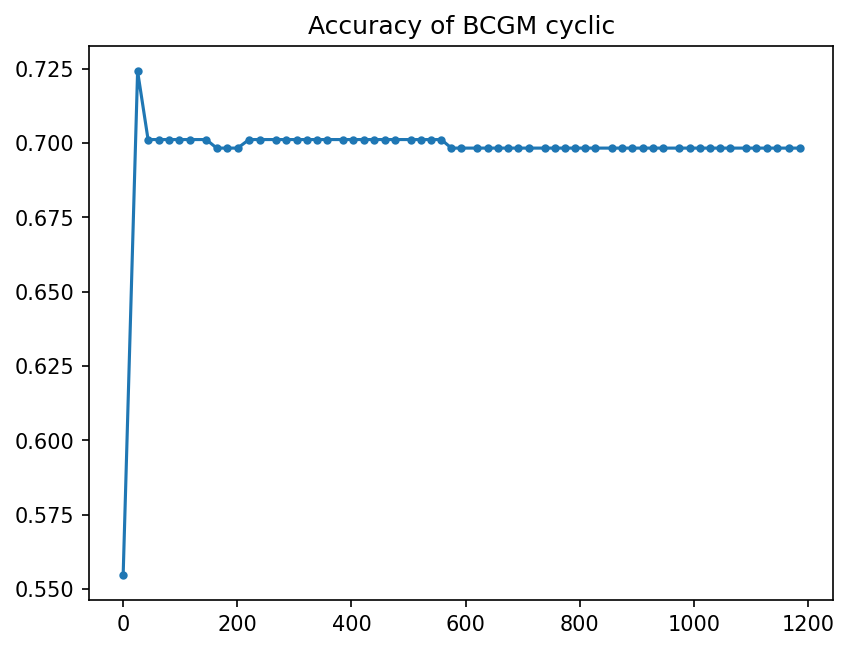

In [71]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM cyclic")
plt.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')

### Gauss-Southwell

In [72]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [73]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 20880 - final accuracy 55.46% - loss 303461.82
10% - iter 2088 / 20880 - final accuracy 69.83% - loss 105546.57
20% - iter 4176 / 20880 - final accuracy 69.83% - loss 105546.57

Final accuracy: 69.83%
Norm gradient: 9.976493577002883e-06
Loss: 105546.56628718572

CPU times: user 304 ms, sys: 4.58 ms, total: 309 ms
Wall time: 309 ms


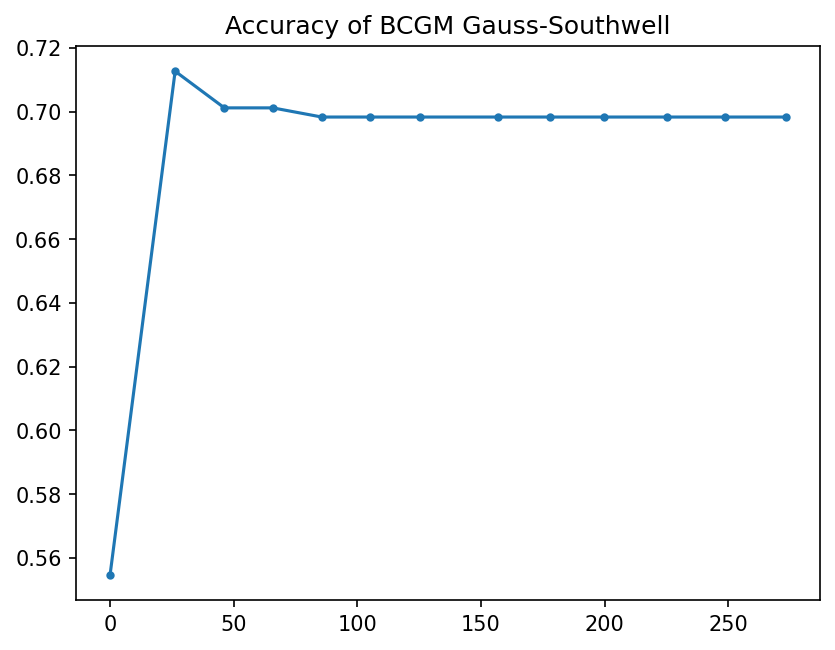

In [74]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')

### Loss

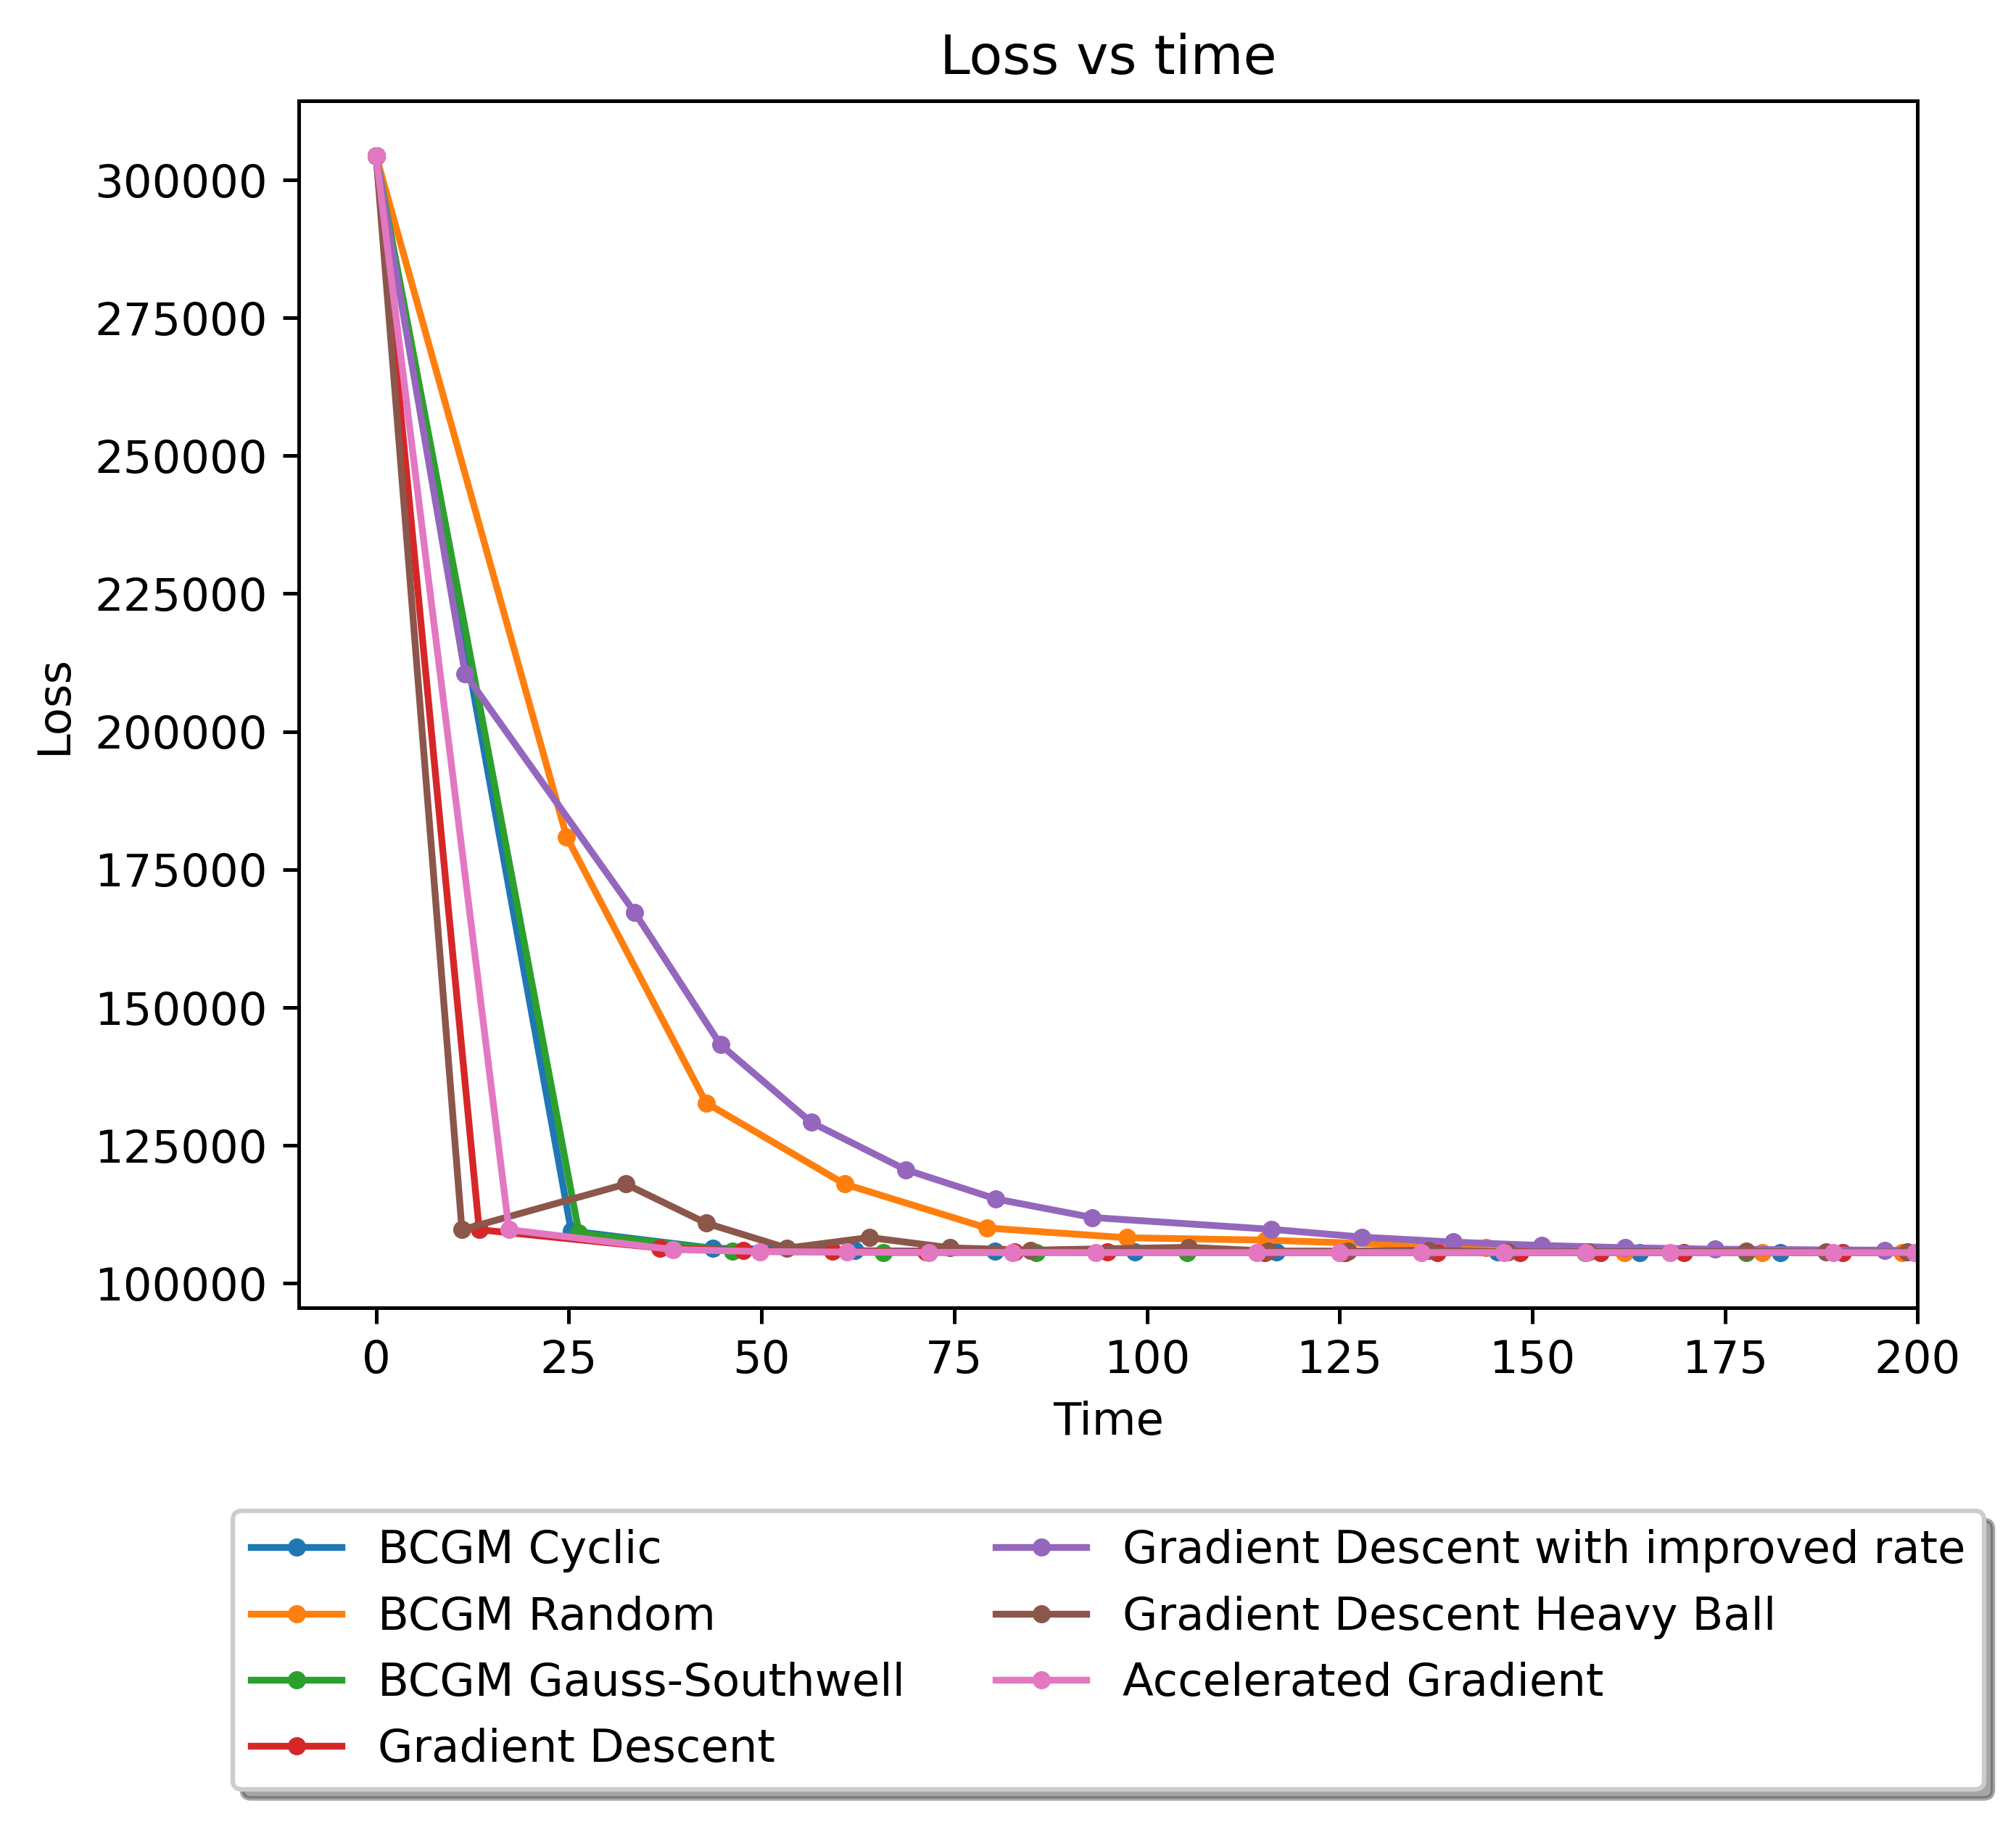

In [78]:
plt.figure(dpi=PLOT_DPI*3)
plt.plot(ticks_bcgd_cyclic , losses_bcgm_cyclic, marker='.')
plt.plot(ticks_bcgd_random , losses_bcgm_random, marker='.')
plt.plot(ticks_bcgd_gs , losses_bcgm_gs, marker='.')
plt.plot(ticks_gd , losses_gd, marker='.')
plt.plot(ticks_gd_improved , losses_gd_improved, marker='.')
plt.plot(ticks_gd_hb , losses_gd_hb, marker='.')
plt.plot(ticks_gd_accelerated , losses_gd_accelerated, marker='.')

plt.title("Loss vs time")
plt.xlabel("Time")
plt.ylabel("Loss")
plt.xlim(-10,200)
plt.legend(
    [
        'BCGM Cyclic',
        'BCGM Random',
        'BCGM Gauss-Southwell',
        'Gradient Descent',
        'Gradient Descent with improved rate',
        'Gradient Descent Heavy Ball',
        "Accelerated Gradient"
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2

)